In [1]:
source("~/smartas/pipeline/scripts/variablesAndFunctions.r")
options(repr.plot.width=10, repr.plot.height=8)

switches.split <- read_tsv("../data/pancancer/candidateList_full.tumorSplit.tsv")

switches <- read_tsv("../data/pancancer/candidateList_full.tsv") %>%
    filter(Reliable==1)

drivers <- read_tsv("../data/intogen_cancer_drivers-2014.12b/Mutational_drivers_per_tumor_type.tsv",comment="#") %>%
  mutate(Tumor_type = ifelse(Tumor_type=="COREAD", "coad", Tumor_type),
         Tumor_type = ifelse(Tumor_type=="HC", "lihc", Tumor_type),
         Tumor_type = ifelse(Tumor_type=="RCCC", "kirc", Tumor_type),
         Tumor_type = tolower(Tumor_type) ) %>%
  set_colnames(c("Symbol","Tumor"))

proteome <- read_tsv("../data/mutations/proteome_information.txt") %>%
    set_colnames(c("Tumor","GeneId","Symbol","Transcript","TPM","ProteinLength","asEvidence"))

wes <- read_tsv("../data/mutations/wes_mutations.txt") %>%
    select(Tumor,Gene,Symbol,Patient) %>%
    unique


Attaching package: ‘dplyr’

The following objects are masked from ‘package:plyr’:

    arrange, count, desc, failwith, id, mutate, rename, summarise,
    summarize

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



In [2]:
# Figure 1
## Figure 1a
f1a <- switches.split  %>%
    filter(NotNoise==1 & IsModel==1) %>%
    mutate(Driver = ifelse(Symbol %in% drivers$Symbol, "1", "0"),
           Driver = revalue(Driver, c("1"="Driver", "0"="Non-driver")),
           Driver = factor(Driver, levels=c("Non-driver","Driver")),
           IsFunctional = revalue(as.character(IsFunctional), c("1"="Functional", "0"="Non-functional"))) %>%
    ggplot(aes(x=Tumor, fill=IsFunctional, alpha=Driver)) +
        geom_bar() +
        labs(x="", fill="Switch", alpha="Gene") +
        scale_fill_manual(values=c("Functional"="firebrick", "Non-functional"="gray")) +
        scale_alpha_manual(values=c("Driver"=1, "Non-driver"=0.5)) +
        smartas_theme() +
        theme(legend.position="bottom")
ggsave("../results/figures/1a.png",f1a)

Saving 7 x 7 in image


In [3]:
## Figure 1b
library(UpSetR)

structural <- lapply(cancerTypes, function(tumor){
    paste0("../data/structural_analysis/",tumor,".structural_summary.tsv") %>%
    read_tsv %>%
    set_colnames(c('GeneId','Symbol','Normal_transcript','Tumor_transcript',
                   'ArchDB','Pfam','IUPRED','ANCHOR','ProSite')) %>%
    mutate(ArchDB = ifelse(ArchDB=="True",1,0),
           Pfam = ifelse(Pfam=="True",1,0),
           IUPRED = ifelse(IUPRED=="True",1,0),
           ANCHOR = ifelse(ANCHOR=="True",1,0),
           ProSite = ifelse(ProSite=="True",1,0))
}) %>% do.call("rbind",.) %>%
    unique %>%
    merge(switches)

png("../results/figures/1b.png")
structural %>%
    select(ArchDB,Pfam,IUPRED,ANCHOR,ProSite) %>%
    # top 20 intersections
    upset(order.by = "freq", nintersects = 10, name.size = 16, line.size = 3, point.size = 8)
dev.off()

Warning message:
: replacing previous import by ‘scales::alpha’ when loading ‘UpSetR’

pdf 
  2

In [4]:
## Figure 1c

In [16]:
## Figure 1d
top.drivers <- switches %>%
    filter(Symbol %in% drivers$Symbol & IsFunctional==1) %>%
    arrange(desc(PatientNumber)) %>%
    top_n(20, PatientNumber) %>%
    mutate(label = paste0(Symbol," (",Normal_transcript,",",Tumor_transcript,")")) %>%
    select(Normal_transcript,Tumor_transcript,label,Symbol)

f1d <- merge(top.drivers, switches.split) %>%
    mutate(label = factor(label, levels=top.drivers$label),
           Symbol = factor(Symbol, levels=top.drivers$Symbol)) %>%
    ggplot(aes(x=Symbol, y=PatientNumber, fill=Tumor)) +
        geom_bar(stat="identity") +
        labs(x="", y="# patients") +
        scale_fill_manual(values=colorPalette) +
        smartas_theme() +
        theme(legend.position="right", axis.text.x = element_text(angle = 90, size=15))

ggsave("../results/figures/1d.png",f1d)

Saving 7 x 7 in image


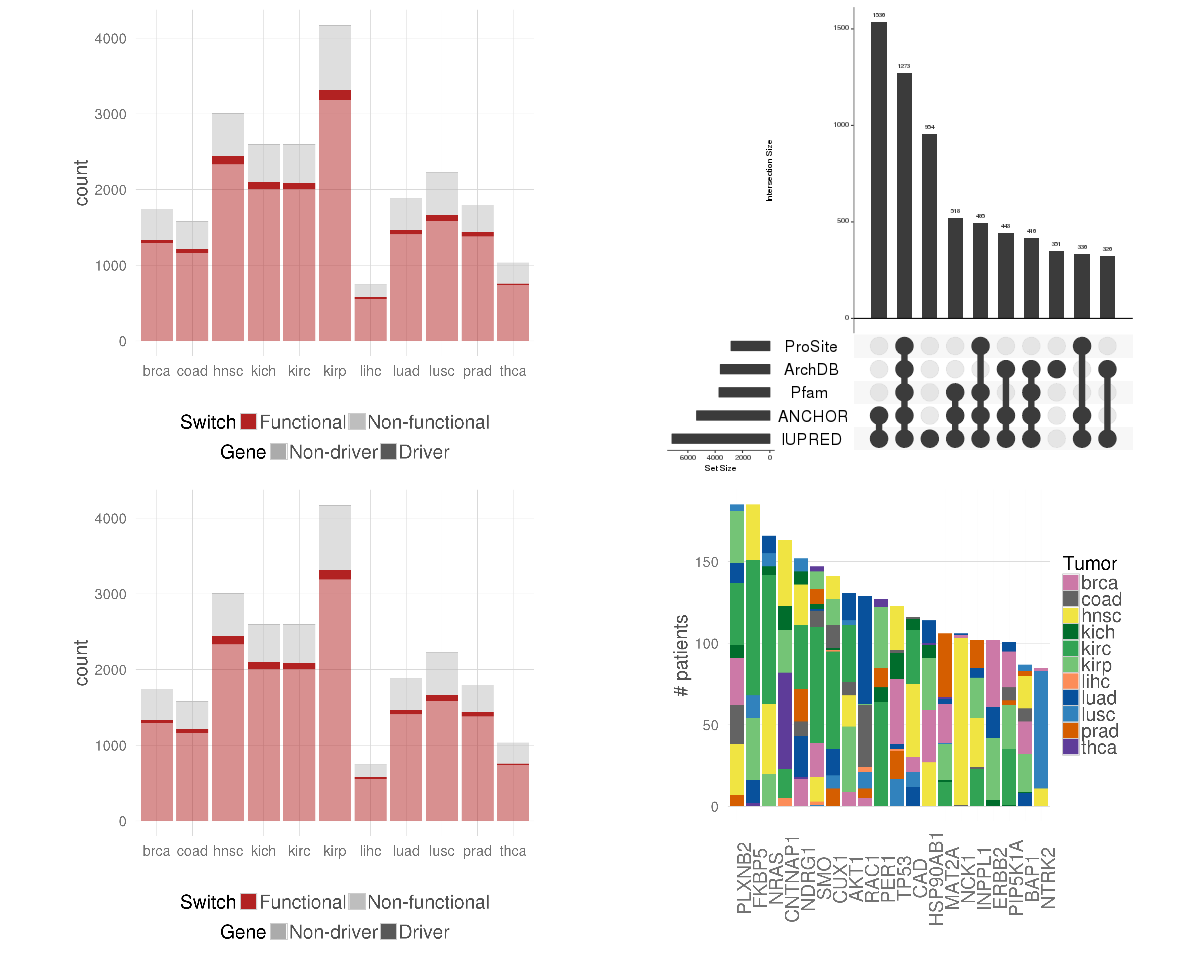

In [15]:
grobs <- lapply(sprintf(file.path("../results/figures/1%s.png"), c("a","b","c","d")), png::readPNG) %>%
    lapply(grid::rasterGrob)
gridExtra::grid.arrange(grobs=grobs, nrow=2, ncol=2)

Figure 1. (A) Number of switches (y axis) calculated in each tumor type (x axis), separated according to whether the switches are functional or not and whether they affect mutational drivers. The number of non-functional switches in drivers is very low in most tumor types. (B) Overlap graph of protein features affected in functional switches. (C) Functional categories associated to protein domain losses significantly enriched in functional isoform switches. For each functional category we give the number of isoform switches in which a protein domain related to this category is lost. (D) Top 50 functional switches in mutational cancer drivers according to the number of patients in which they occur. We indicate in color the tumor type. 

In [22]:
# Figure 2
## Figure 2a

library(scales)

# count number of genes altered per patient
## WES mutation
genesPAM.perPatient <- wes %>%
    group_by(Tumor,Patient) %>%
    summarise(PAM=length(Patient))

## a functional switch
genesSwitched.perPatient <- switches$Patients_affected[switches$IsFunctional==1] %>%
    strsplit(",") %>% unlist %>%
    table %>% as.data.frame %>%
    set_colnames(c("Patient","Switch"))

# use number of spliced genes and total number of genes to normalize the observations
lines <- "Tumor\tSplicedGenes\tGenes\nbrca\t12383\t20530\nprad\t11849\t20530\nthca\t11812\t20530\ncoad\t11498\t20530\nhnsc\t11583\t20530\nkich\t11607\t20530\nkirc\t12205\t20530\nkirp\t11853\t20530\nlihc\t10490\t20530\nluad\t12046\t20530\nlusc\t12070\t20530\n"
consideredGenes <- read_tsv(lines) %>%
    set_colnames(c("Tumor","SplicedGenes","Genes"))

recurrence <- merge(genesSwitched.perPatient,genesPAM.perPatient,all=T) %>%
    merge(consideredGenes) %>%
    mutate(PAM=PAM/Genes, Switch=Switch/SplicedGenes) %>%
    select(everything(),-contains("Genes"))

# show lack of correlation between mutations and switches
f2a <- recurrence %>%
    ggplot(aes(x=Switch,y=PAM)) + 
        geom_point(aes(color=Tumor)) + 
        smartas_theme() +
        scale_color_manual(values=colorPalette) + 
        theme(legend.position="bottom") +
        labs(x="Genes with a functional switch", y="Genes with a PAM") +
        scale_y_continuous(labels = percent) +
        scale_x_continuous(labels = percent)
ggsave("../results/figures/2a.png",f2a)

Saving 7 x 7 in image
Warning message:
: Removed 164 rows containing missing values (geom_point).

In [124]:
## Figure 2b
MS.pfams <- read_tsv("../results/pfam_enrichment_analysis.tsv") %>%
    filter((adjp_g < 0.05 | adjp_l < 0.05) & adjp_m < 0.05) %>%
    select(Feature, switches_g, switches_l) %>%
    mutate(Feature = unlist(strsplit(Feature,"|", fixed=T))[c(F,T)],
           Feature = gsub("_"," ",Feature)) %>%
    reshape2::melt(id.vars = "Feature") %>%
    set_colnames(c("Feature","What","NumSwitches")) %>%
    filter(NumSwitches != 0) %>%
    mutate(What = ifelse(What=="switches_l", "Lost", "Gained"),
           What = factor(What, levels=c("Lost","Gained")))

f2b <- MS.pfams %>%
    mutate(NumSwitches = ifelse(What=="Lost", NumSwitches, -NumSwitches)) %>%
    arrange(NumSwitches) %>%
    mutate( Feature = factor(Feature, levels=Feature)) %>%
    ggplot(aes(y=Feature, fill=NumSwitches, label=abs(NumSwitches))) +
        geom_tile(aes(x=1), stat="identity") +
        geom_text(aes(x=1),size=6) +
        scale_fill_gradient2(low = "#e08214", high = "#8073ac", limits=c(56,-56)) +
        labs(y="", x="") +
        smartas_theme() +
        facet_grid(What~., scales="free",drop=T,space="free") +
        theme(axis.text.y = element_text(size=15), axis.text.x = element_blank())

ggsave("../results/figures/2b.png",f2b)

Saving 7 x 7 in image


In [9]:
## Figure 2c


In [10]:
## Figure 2d

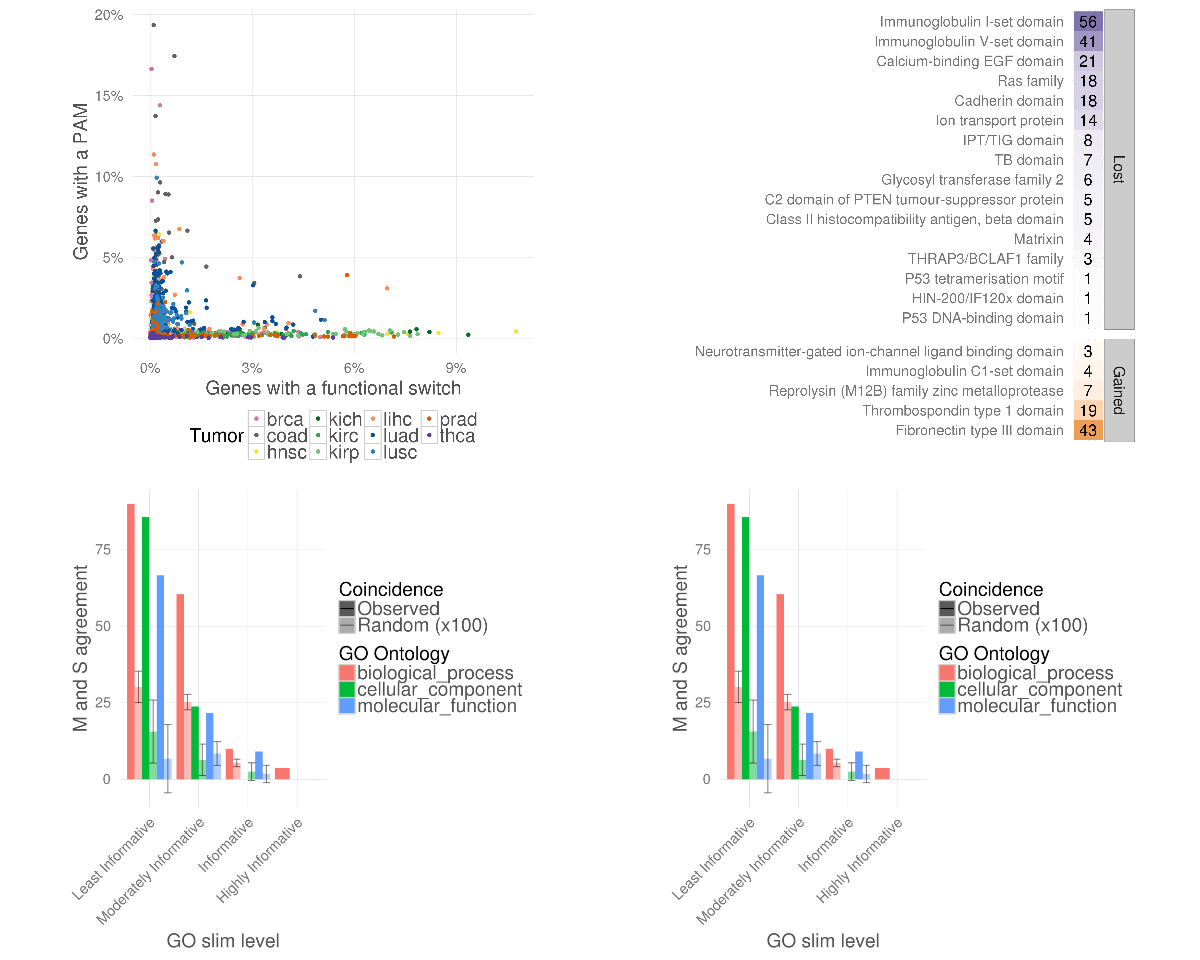

In [125]:
grobs <- lapply(sprintf(file.path("../results/figures/2%s.png"), c("a","b","c","d")), png::readPNG) %>%
    lapply(grid::rasterGrob)
gridExtra::grid.arrange(grobs=grobs, nrow=2, ncol=2)

**Figure 2.** (A) For each patient sample, colored according to tumor type, we indicate the proportion of all genes with protein affecting mutations (PAMs) in the sample (y axis), and the proportion of genes with multiple transcript isoforms that present a functional isoform switch in the same sample (x axis). (B) Domain classes that are are enriched in losses (left panel) or gains (right panel) in isoform switches that are also enriched in protein-affecting mutations tumors. For each domain class we indicate the number of switches (C) Agreement between protein-affecting mutations and functional switches (y axis) in terms of the functional categories of the protein domains they affect, using 3 different gene ontologies (GO) and at four different GO Slim levels, from most specific (most informative) to the least specific (least informative). Random occurrences were calculated by sampling 100 times the same number of domain classes affected by functional switches or by protein-affecting mutations. (D) Pairs formed by a mutational driver and a functional isoform switch that belong to the same functional pathway and show mutual exclusion of PAMs and switches across patients in at least one tumor type (color coded by tumor type). The graph indicates the percentage of samples where the switch occurs (x axis) and the percentage of samples where the driver is mutated in the same tumor type. Each pair is represented with the gene symbol that has the switch and the mutational driver gene symbol (in parenthesis). 

In [11]:
# Figure 3
# generate oncoprints for all 
# structural_analysis/create_oncoprints.R